Load external packages

In [1]:
from pathlib import Path

import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

from albumentations import (
    Compose,
    Transpose,
    RandomRotate90,
    OneOf,
    RGBShift,
    HueSaturationValue
)

Using TensorFlow backend.


Create two instances with the same arguments

In [2]:
data_gen_args = dict(horizontal_flip=True, vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
gt_datagen = ImageDataGenerator(**data_gen_args)

Provide the same seed and keyword arguments to the fit and flow methods

In [3]:
seed = 31
image_generator = image_datagen.flow_from_directory(
    '/tf/scripts/input/train_bin_256/image',
    class_mode=None,
    seed=seed)

gt_generator = gt_datagen.flow_from_directory(
    '/tf/scripts/input/train_bin_256/gt',
    class_mode=None,
    seed=seed)

Found 10080 images belonging to 1 classes.
Found 10080 images belonging to 1 classes.


Transform image for augmentation

In [4]:
aug = Compose([
    OneOf([
        Transpose(p=0.5),
        RandomRotate90(p=0.5)
    ], p=0.5),
    OneOf([
        RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
        HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10)
    ], p=0.3)
])

def transform(img_batch, gt_batch):
    batch_auged = (aug(image=img, mask=gt) for img, gt in zip(img_batch, gt_batch))
    imgs_auged, gts_auged = zip(*((auged['image'], auged['mask']) for auged in batch_auged))
    return imgs_auged, gts_auged

Combine generators into one which yields image and masks

In [5]:
train_generator = (transform(img_batch, gt_batch) for img_batch, gt_batch in zip(image_generator, gt_generator))

To test combined train_generator, check images in batch on figure

In [6]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [7]:
images, gts = next(train_generator)

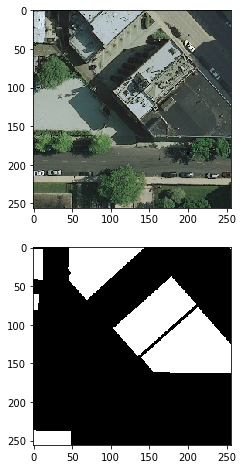

In [8]:
visualize(images[0].astype(np.uint8), gts[0].astype(np.uint8))